In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import DifferentialActionModelPointMass

In [2]:
nx = 4
nu = 2
T = 50
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs0 = Obstacle(10, 8, 2, 1, 'Obs0')
obs1 = Obstacle(10, 8, 1, 2, 'Obs1')
obs2 = Obstacle(8, 10, 1, 2, 'Obs2')
obs3 = Obstacle(8, 8, 1, 2, 'Obs3')
obs_set = [obs1, obs2, obs3]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)

nr = cost_set.nr

In [3]:
# Desired Running and Terminal Model
w_run = np.array([10, 1., 1., 1000, 1000, 1000])
w_term = np.array([2000, 1., 1., 1000, 1000, 1000])
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_des[:nr]; w_term = w_des[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_opt = mim_solvers.SolverSQP(problem)
sqp_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_opt.with_callbacks=True
sqp_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_opt.solve(xs_init, us_init, 500)
xs_optimal = np.stack(sqp_opt.xs.tolist().copy())
us_optimal = np.stack(sqp_opt.us.tolist().copy())
print(done)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.01250e+02  1.01250e+02  2.91940e+01  1.0000  0.00000e+00  9.97972e+00
   2  3.01609e+00  3.01609e+00  5.59573e-02  1.0000  1.75138e-14  7.55501e-02
   3  2.97331e+00  2.97331e+00  3.58745e-01  1.0000  5.06917e-11  3.11857e-01
   4  2.77491e+00  2.77491e+00  7.12445e-01  1.0000  3.36121e-10  3.16733e-01
   5  2.61731e+00  2.61731e+00  7.62747e-02  1.0000  1.26762e-09  3.42886e-02
   6  2.60863e+00  2.60863e+00  6.07051e-02  1.0000  1.50395e-10  2.25152e-02
   7  2.60256e+00  2.60256e+00  5.00395e-02  1.0000  8.99342e-11  1.57213e-02
   8  2.59798e+00  2.59798e+00  3.02300e-01  1.0000  1.00357e-10  4.55592e-02
   9  2.57729e+00  2.57729e+00  2.69517e-01  1.0000  8.58399e-10  1.78476e-02
  10  2.56338e+00  2.56338e+00  2.54828e-01  1.0000  6.00672e-10  7.75933e-03
iter     merit         cost         grad      step    ||gaps||        KKT
  11  2.55130e+00  2.55130e+00  2.53501e-02  1.0000  5.87056e-10  1.7490

In [4]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())

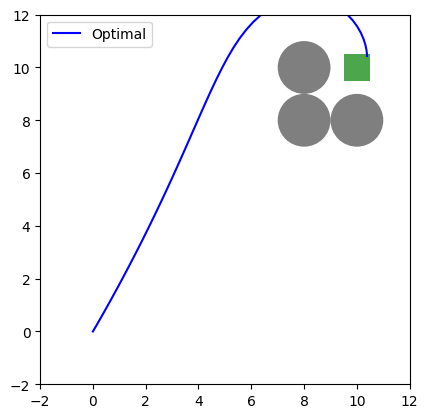

In [5]:
plot_1_traj(xs_optimal, obs_set, target_high, label='Optimal', linemap = 'b')

In [6]:
# Bad Running and Terminal Model
w_run = np.array([10, 1., 1., 0., 0., 0.])
w_term = np.array([1000, 1., 1., 0., 0., 0.])
# w_bad = np.hstack([w_run, w_term])
w_bad = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_bad = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_bad[:nr]; w_term = w_bad[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_non_opt = mim_solvers.SolverSQP(problem)
sqp_non_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_non_opt.with_callbacks=True
sqp_non_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_non_opt.solve(xs_init, us_init, 500)
xs_non_optimal = np.stack(sqp_non_opt.xs.tolist().copy())
us_non_optimal = np.stack(sqp_non_opt.us.tolist().copy())
print(done)


iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.02500e+02  1.02500e+02  2.91355e+01  1.0000  0.00000e+00  9.95982e+00
True
 END  1.57572e+00  1.57572e+00  1.18130e-04   ----   2.33424e-14  1.58227e-06


In [7]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())

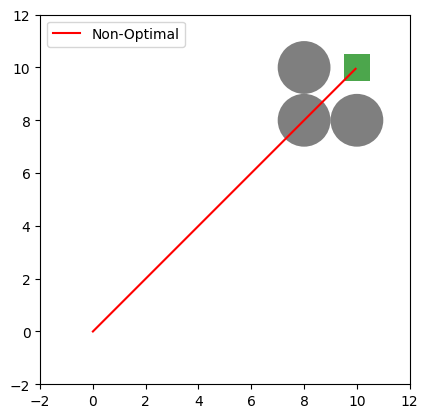

In [8]:
plot_1_traj(xs_non_optimal, obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [9]:
print('Desired Trajectory Cost:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep), ' || other Trajectory, same cost:   ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_des[:nr], w_des[nr:], timeStep))
print('Bad Trajectory Cost:      ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_bad[:nr], w_bad[nr:], timeStep), ' || other Trajectory, same cost:   ', cost_set.traj_cost(xs_optimal, us_optimal, w_bad[:nr], w_bad[nr:], timeStep))

Desired Trajectory Cost:   1.4880389633500672  || other Trajectory, same cost:    3.0567155566599604
Bad Trajectory Cost:       1.5757213680064326  || other Trajectory, same cost:    2.3730406817074345


In [10]:
###### IRL #######

In [11]:
# generating bad trajectories
num_bad = 10
scales = 5.0
xs_non_optimal_set = []
us_non_optimal_set = []
xs_non_optimal_set.append(np.stack(xs_non_optimal.tolist()).copy())
us_non_optimal_set.append(np.stack(us_non_optimal.tolist()).copy())
for _ in range(num_bad):
    # # Get one non-optimal sample from non-optimal demo
    Us = us_non_optimal.copy()+np.random.normal(0,scales,np.stack(us_non_optimal.tolist()).shape)
    us_non_optimal_set.append(Us)
    xs_non_optimal_set.append(np.stack(problem.rollout([Us[i] for i in range(T)])))
    # # Get one non-optimal sample from optimal demo
    Us = us_optimal.copy()+np.random.normal(0,scales,np.stack(us_non_optimal.tolist()).shape)
    us_non_optimal_set.append(Us)
    xs_non_optimal_set.append(np.stack(problem.rollout([Us[i] for i in range(T)])))

In [12]:
opt_cost = np.exp(-cost_set.traj_cost(xs_optimal,us_optimal,w_des[:nr], w_des[nr:], timeStep))
print(opt_cost)
for X, U in zip(xs_non_optimal_set, us_non_optimal_set):
    print('Modified: ', np.exp(-cost_set.traj_cost(X,U,w_bad[:nr], w_bad[nr:], timeStep))/opt_cost, 
         'Original: ', np.exp(-cost_set.traj_cost(X,U,w_bad[:nr], w_bad[nr:], timeStep)))

0.22581505321409506
Modified:  0.9160517643034812 Original:  0.20685827790305628
Modified:  0.003454940266531608 Original:  0.0007801775201383549
Modified:  3.1306256905791037e-06 Original:  7.069424069115334e-07
Modified:  0.06898455969521959 Original:  0.015577752018526929
Modified:  0.006261629876278309 Original:  0.0014139702837187539
Modified:  0.00048389298726812276 Original:  0.00010927032066987857
Modified:  0.03042998553752142 Original:  0.006871548803459543
Modified:  4.410541001748438e-11 Original:  9.959665510127716e-12
Modified:  9.442362099012943e-08 Original:  2.132227499855362e-08
Modified:  4.961880664979069e-05 Original:  1.1204673464042378e-05
Modified:  0.01785351068082858 Original:  0.00403159146444972
Modified:  1.3491476432831539e-06 Original:  3.0465784686165633e-07
Modified:  0.03628533578936201 Original:  0.00819377503216609
Modified:  0.017287797638686802 Original:  0.003903844943734567
Modified:  0.007140379916262183 Original:  0.0016124052707596004
Modified

In [13]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    # x /= np.linalg.norm(x)
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        den += np.exp(-cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_nSamples(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, samples, Lambda = 0.001):
    nr = cost_set.nr
    num_samples = samples # Have these number of samples per trajectory equidistantly starting from the beginning
    output = 0
    for i in np.int32(np.linspace(0, len(xs_optimal), num=num_samples+1))[:-1]:
        num = np.nextafter(0,1)
        den = np.nextafter(0,1)
        X_opt = xs_optimal[i:].copy(); U_opt = us_optimal[i:].copy()
        num += np.exp(-cost_set.traj_cost(X_opt, U_opt, x[:nr], x[nr:], dt))
        den += num
        for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
            X_nopt = Xs[i:].copy(); U_nopt = Us[i:].copy()
            den += np.max([np.nextafter(0,1), np.exp(-cost_set.traj_cost(X_nopt, U_nopt, x[:nr], x[nr:], dt))])
        output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_cum(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    return True

# def fcn_w_nD(x, cost_set, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
#     # x /= np.linalg.norm(x)
#     nr = cost_set.nr
#     output = 0
#     for Xs_opt, Us_opt in zip(xs_optimal_set, us_optimal_set):
#         num = np.nextafter(0,1)
#         den = np.nextafter(0,1)
#         num += np.exp(-cost_set.traj_cost(Xs_opt, Us_opt, x[:nr], x[nr:], dt))
#         den += num
#         for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
#             den += np.exp(-cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt))
#         output -= np.log(num/den)
    
#     output += Lambda*np.linalg.norm(x)
#     return output



In [37]:
dt = timeStep
Lambda = 0.0001
lb = 0.0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 100, 'iprint': 1,'ftol': 1e-15 ,'gtol' : 1e-15}
tol = 1e-15
samples = 1
# w0 = w_bad
w0 = np.zeros_like(w_bad)
# w0 = w_des
# w0 = 10*np.ones_like(w_bad)

# 1 Optimal Demo
args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda)
res = minimize(fcn_w, 
               w0, 
               args, 
               bounds=bnds, 
               method='L-BFGS-B', 
               tol = tol,
               options=options)
print(res)

# 1 Optimal Demo, Multiple Samples
# args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, samples, Lambda)
# res = minimize(fcn_w_nSamples, 
#                w0, 
#                args, 
#                bounds=bnds, 
#                method='L-BFGS-B', 
#                tol = tol,
#                options=options)
# print(res)


# WIRL = []
# for i in range(1,len(xs_non_optimal_set)):
#     xs_no_subset = xs_non_optimal_set[:i]
#     us_no_subset = us_non_optimal_set[:i]
#     res = minimize(fcn_w, 
#                    w0, 
#                    args=(cost_set, xs_optimal, us_optimal, xs_no_subset, us_no_subset, dt, Lambda), 
#                    bounds=bnds, 
#                    method='L-BFGS-B', 
#                    tol = tol,
#                    options=options)
#     WIRL.append(res.x)
#     print(res)

w_irl = res.x

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0        12 variables are exactly at the bounds

At iterate    0    f=  3.09104D+00    |proj g|=  9.37833D+00

At iterate    1    f=  2.97455D+00    |proj g|=  6.66600D+00

At iterate    2    f=  2.69399D+00    |proj g|=  5.49854D+00

At iterate    3    f=  1.87954D+00    |proj g|=  2.68892D+00

At iterate    4    f=  1.42344D+00    |proj g|=  1.50817D+00

At iterate    5    f=  1.06499D+00    |proj g|=  8.99668D-01

At iterate    6    f=  8.54075D-01    |proj g|=  9.02848D-01

At iterate    7    f=  6.90187D-01    |proj g|=  8.48270D-01

At iterate    8    f=  5.18928D-01    |proj g|=  7.19646D-01

At iterate    9    f=  4.97619D-01    |proj g|=  7.01667D-01

At iterate   10    f=  3.80384D-01    |proj g|=  5.75223D-01

At iterate   11    f=  2.21351D-01    |proj g|=  3.60713D-01

At iterate   12    f=  8.63678D-02    |proj g|=  1.48981D-01

At iterate   13    f=  4.4

In [38]:
# w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.005 IRL:  0.0
Terminal ||  Desired:  1.0 IRL:  3.9863421898680986

XReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.04145191519225497

UReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.0

Obs1 :
Running ||  Desired:  0.5 IRL:  1.7918459079303395
Terminal ||  Desired:  0.5 IRL:  0.7035556396536423

Obs2 :
Running ||  Desired:  0.5 IRL:  2.097053490926384
Terminal ||  Desired:  0.5 IRL:  1.0978593181614333

Obs3 :
Running ||  Desired:  0.5 IRL:  4.261170769240397
Terminal ||  Desired:  0.5 IRL:  0.07425326044133627



In [39]:
# w_irl = w_irl/np.max(w_irl)

In [40]:
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep), ' || with IRL Weight:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
print('Bad Trajectory Cost:     ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_bad[:nr], w_bad[nr:], timeStep), ' || with IRL Weight:  ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_irl[:nr], w_irl[nr:], timeStep))

Desired Trajectory Cost:  1.4880389633500672  || with IRL Weight:   5.701539795513118
Bad Trajectory Cost:      1.5757213680064326  || with IRL Weight:   15.94687836662912


In [41]:
# Test IRL 1D Output
print('Desired Fcn:    ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('IRL Fcn:        ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('Bad Fcn:        ', fcn_w(w_bad, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))

Desired Fcn:     0.3706918127144126
IRL Fcn:         0.0007205052143068357
Bad Fcn:         1.327214742787381


In [42]:
# Run again with bad weights (zero for obstacles)
w_run = w_irl[:nr]
w_term = w_irl[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
# x0 = np.array([5.0, 10.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp = mim_solvers.SolverSQP(problem)
sqp.setCallbacks([crocoddyl.CallbackVerbose()])
sqp.with_callbacks=True
sqp.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]
# xs_init = [xs_optimal[i] for i in range(T+1)]
# us_init = [us_optimal[i] for i in range(T)]

# Solving this problem
done = sqp.solve(xs_init, us_init, 500)
xs_output = np.stack(sqp.xs.tolist().copy())
us_output = np.stack(sqp.us.tolist().copy())

iter     merit         cost         grad      step    ||gaps||        KKT
   1  3.98634e+02  3.98634e+02  2.66794e+01  1.0000  0.00000e+00  3.98634e+01
   2  1.32865e+01  1.32865e+01  1.40591e-01  1.0000  1.71807e-14  4.66518e-01
   3  1.30004e+01  1.30004e+01  2.75487e+00  0.5000  1.32727e-10  4.89017e+00
   4  1.24038e+01  1.24038e+01  4.25144e-01  1.0000  2.06427e-09  9.54700e-01
   5  1.20016e+01  1.20016e+01  2.50366e+00  1.0000  6.73986e-10  5.24838e-01
   6  1.08531e+01  1.08531e+01  1.93986e+00  1.0000  4.41653e-09  2.29910e-01
   7  1.00622e+01  1.00622e+01  1.93800e+01  1.0000  3.78976e-09  1.64762e+00
   8  5.97277e+00  5.97277e+00  3.15400e+00  1.0000  5.21002e-08  8.38920e-01
   9  5.46151e+00  5.46151e+00  1.45638e+01  1.0000  9.04534e-09  5.36567e-01
  10  5.20734e+00  5.20734e+00  2.00452e+00  1.0000  2.44929e-08  1.70962e-01
iter     merit         cost         grad      step    ||gaps||        KKT
  11  5.16474e+00  5.16474e+00  1.95963e+01  1.0000  4.01287e-09  8.2953

In [43]:
print('IRL Trajectory Cost:  ', cost_set.traj_cost(xs_output, us_output, w_irl[:nr], w_irl[nr:], timeStep))
print('with Desired Weight:  ', cost_set.traj_cost(xs_output, us_output, w_des[:nr], w_des[nr:], timeStep)) 
print('with Bad Weight:      ', cost_set.traj_cost(xs_output, us_output, w_bad[:nr], w_bad[nr:], timeStep))

IRL Trajectory Cost:   5.063065548714506
with Desired Weight:   5.480056471421784
with Bad Weight:       10.141940551490833


In [44]:
print('IRL Trajectory Cost:      ', cost_set.traj_cost(xs_output, us_output, w_irl[:nr], w_irl[nr:], timeStep))
print('Desired Trajectory Cost:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))

IRL Trajectory Cost:       5.063065548714506
Desired Trajectory Cost:   1.4880389633500672


In [45]:
print('IRL Trajectory with Desired Cost: ', cost_set.traj_cost(xs_output, us_output, w_des[:nr], w_des[nr:], timeStep))
print('Initial Optimal Trajectory Cost:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))

IRL Trajectory with Desired Cost:  5.480056471421784
Initial Optimal Trajectory Cost:   1.4880389633500672


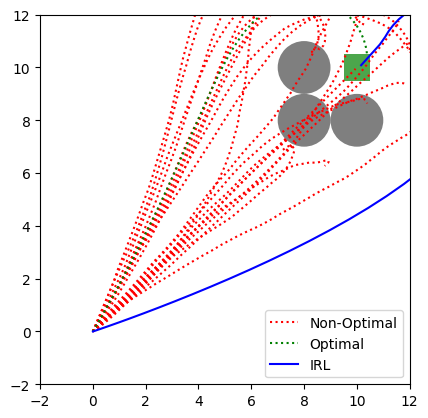

In [46]:
plot_results(xs_optimal, xs_non_optimal_set, xs_output, obs_set, target_high)

In [47]:
P_irl = distributions(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, w_des[:nr], w_des[nr:], dt)   

In [48]:
P_irl/np.max(P_irl)

array([1.00000000e+00, 3.55227021e-05, 7.69873049e-14, 3.59432813e-21,
       1.65698197e-10, 3.04079600e-09, 3.35264549e-16, 2.18206171e-05,
       2.40684808e-41, 3.39543878e-27, 2.59250678e-18, 1.17006483e-06,
       1.08462234e-24, 3.33264340e-06, 2.17403720e-10, 1.26253849e-07,
       1.08433745e-09, 1.21203661e-08, 3.39139109e-15, 7.54926840e-28,
       1.99271540e-09, 9.51462618e-26])

In [49]:
P_des/np.max(P_des)

array([1.00000000e+00, 2.08320693e-01, 1.60356231e-03, 1.24091902e-05,
       5.22424676e-03, 3.28764104e-03, 4.51003436e-04, 8.19493534e-02,
       9.96739001e-11, 3.27313859e-07, 3.67201283e-05, 4.33033259e-02,
       9.15934535e-07, 2.48468816e-02, 1.37047924e-02, 2.40770295e-02,
       6.36223439e-03, 1.35950658e-02, 5.47450465e-04, 2.57898192e-07,
       2.11830796e-02, 4.83700642e-07])

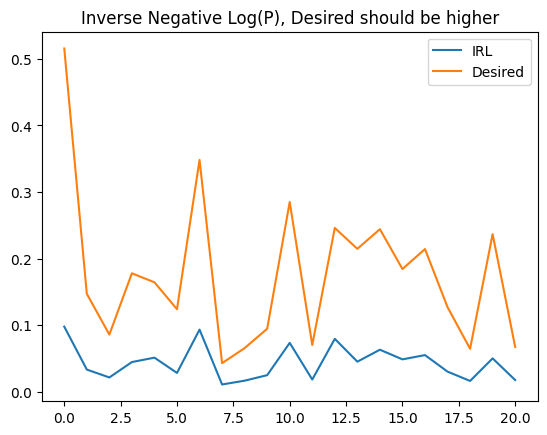

In [50]:
plt.plot(-1/np.log(P_irl[1:]),label='IRL')
plt.plot(-1/np.log(P_des[1:]),label='Desired')
plt.legend()
plt.title('Inverse Negative Log(P), Desired should be higher')
plt.show()